<a href="https://colab.research.google.com/github/IIF0403/Project/blob/master/LSTM_FCN_classifier_for_UCR_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [332]:
#%reload_ext autoreload
#%autoreload 2
%matplotlib inline

import pathlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
#from sklearn.metrics import accuracy_score


In [319]:
def load_data(Dataset): #Function for loading the data saved in github
  url_raw = 'https://raw.githubusercontent.com/IIF0403/timeseries/master/data/' 
  
  url_train = url_raw + Dataset+'/'+Dataset+'_TRAIN'
  data_train = pd.read_csv(url_train)
  x_train = data_train.iloc[:,1:].to_numpy()
  y_train = data_train.iloc[:,0].to_numpy()
  
  url_test = url_raw + Dataset+'/'+Dataset+'_TEST'
  data_test = pd.read_csv(url_test)
  x_test = data_test.iloc[:,1:].to_numpy()
  y_test = data_test.iloc[:,0].to_numpy() 

  return x_train, y_train, x_test, y_test

def create_dataset(X, y, device):
  X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

  #Some of the datasets has classes starting from 1, need them to start from 0
  if ( ((y_train==0).sum())==0 ): #If there is no class 0
    y_tensor = torch.tensor(y, dtype=torch.long, device=device)-1
  else:
    y_tensor = torch.tensor(y, dtype=torch.long, device=device)

  return TensorDataset(X_tensor, y_tensor)



In [333]:
#dataset = "Adiac"
dataset= "ArrowHead"
#dataset= "Beef"


X_train, y_train, X_test, y_test = load_data(dataset)

print('X_train %s   y_train %s' % (X_train.shape, y_train.shape))
print('X_test  %s   y_test  %s' % (X_test.shape, y_test.shape))

#Hva burde man ha som batch size ??
#bs=64
bs = 29
classes = len(np.unique(y_train))

#list with count for each class in train_set, class_count[i] = count for class i 
#class_count = [(y_train == i).sum() for i in range(classes+1)]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load training and test sets into PyTorch Dataset object
train_ds = create_dataset(X_train, y_train, device)
test_ds  = create_dataset(X_test, y_test, device)


#Pass dataset object into DataLoader
train_dl = DataLoader(train_ds, batch_size = bs, shuffle=False)
test_dl = DataLoader(test_ds, batch_size = bs, shuffle=False)



X_train (35, 251)   y_train (35,)
X_test  (174, 251)   y_test  (174,)


In [334]:
#Just checking the sizes
print("Batch_size: ", bs)  

for x , y in train_dl:
  print("x_train shape on PyTorch: ", x.size())
  print("y_train shape on PyTorch: ", y.size())
  print(y)

for x, y in test_dl:
  print("x_test shape on PyTorch: ", x.size())
  print("y_test shape on PyTorch: ", y.size())

Batch_size:  29
x_train shape on PyTorch:  torch.Size([29, 251])
y_train shape on PyTorch:  torch.Size([29])
tensor([1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
        1, 2, 0, 1, 2])
x_train shape on PyTorch:  torch.Size([6, 251])
y_train shape on PyTorch:  torch.Size([6])
tensor([0, 1, 2, 0, 1, 2])
x_test shape on PyTorch:  torch.Size([29, 251])
y_test shape on PyTorch:  torch.Size([29])
x_test shape on PyTorch:  torch.Size([29, 251])
y_test shape on PyTorch:  torch.Size([29])
x_test shape on PyTorch:  torch.Size([29, 251])
y_test shape on PyTorch:  torch.Size([29])
x_test shape on PyTorch:  torch.Size([29, 251])
y_test shape on PyTorch:  torch.Size([29])
x_test shape on PyTorch:  torch.Size([29, 251])
y_test shape on PyTorch:  torch.Size([29])
x_test shape on PyTorch:  torch.Size([29, 251])
y_test shape on PyTorch:  torch.Size([29])


**Classifier**

FCN block: The core component of a FCN is a convolutional block that contains


*   Convolutional layer with filter size of 128 or 256
*   Batch normalizatopn layer with momentum 0.99 and epsilon 0.001
* a ReLU activation at the en dof the block
* an optional squeeze excite block

In [348]:
class BlockFCNConv(nn.Module):
  def __init__(self, in_channel=1, out_channel=128, kernel_size=8, momentum=0.99, epsilon=0.001, squeeze=False):
    super().__init__()
    self.conv = nn.Conv1d(in_channel, out_channel, kernel_size=kernel_size)
    self.batch_norm = nn.BatchNorm1d(num_features=out_channel, eps=epsilon, momentum=momentum)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    # input (batch_size, num_variables, time_steps), e.g. (128, 1, 512)
    x = self.conv(x)
    # input (batch_size, out_channel, L_out)
    x = self.batch_norm(x)
    # same shape as input
    y = self.relu(x)
    return y

The fully convolutional block contains three of these convolutional blocks, used as a feature extractor. Then it uses a global average pooling layer to generate channel_wise statistics

In [347]:
class BlockFCN(nn.Module):
  def __init__(self, time_steps, channels=[1, 128, 256, 128], kernels=[8, 5, 3], mom=0.99, eps=0.001):
    super().__init__()
    self.conv1 = BlockFCNConv(channels[0], channels[1], kernels[0], momentum=mom, epsilon=eps, squeeze=True)
    self.conv2 = BlockFCNConv(channels[1], channels[2], kernels[1], momentum=mom, epsilon=eps, squeeze=True)
    self.conv3 = BlockFCNConv(channels[2], channels[3], kernels[2], momentum=mom, epsilon=eps)
    output_size = time_steps - sum(kernels) + len(kernels)
    self.global_pooling = nn.AvgPool1d(kernel_size=output_size)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    # apply Global Average Pooling 1D
    y = self.global_pooling(x)
    return y


In [349]:
#LSTM block: A shuffle layer + LSTM lauer + dropout layer
class BlockLSTM(nn.Module):
  def __init__(self, time_steps, num_layers, lstm_hs, dropout=0.8, attention=False):
    super().__init__()
    self.lstm = nn.LSTM(input_size=time_steps, hidden_size=lstm_hs, num_layers=num_layers)
    self.dropout = nn.Dropout(p=dropout)
  def forward(self, x):
    # input is of the form (batch_size, num_layers, time_steps), e.g. (128, 1, 512)
    x = torch.transpose(x, 0, 1)
    # lstm layer is of the form (num_layers, batch_size, time_steps)
    x, (h_n, c_n) = self.lstm(x)
    # dropout layer input shape (Sequence Length, Batch Size, Hidden Size * Num Directions)
    y = self.dropout(x)
    # output shape is same as Dropout intput
    return y

#LSTM-FCN
class LSTMFCN(nn.Module):
  def __init__(self, time_steps, num_variables=1, lstm_hs=256, channels=[1, 128, 256, 128]):
    super().__init__()
    self.lstm_block = BlockLSTM(time_steps, 1, lstm_hs)
    self.fcn_block = BlockFCN(time_steps)
    self.dense = nn.Linear(channels[-1] + lstm_hs, num_variables)
    self.softmax = nn.LogSoftmax(dim=1) #nn.Softmax(dim=1)
  def forward(self, x):
    # input is (batch_size, time_steps), it has to be (batch_size, 1, time_steps)
    x = x.unsqueeze(1)
    # pass input through LSTM block
    x1 = self.lstm_block(x)
    x1 = torch.squeeze(x1)
    # pass input through FCN block
    x2 = self.fcn_block(x)
    x2 = torch.squeeze(x2)
    # concatenate blocks output
    x = torch.cat([x1, x2], 1)
    # pass through Linear layer
    x = self.dense(x)
    #x = torch.squeeze(x)
    # pass through Softmax activation
    y = self.softmax(x)
    return y


In [338]:
time_steps = X_train.shape[1]
num_variables = classes
print(num_variables)

#FCN-model
#model = FCN(time_steps)#.cuda()

#LSTM-FCN-model
model = LSTMFCN(time_steps, num_variables)#.cuda()
#print(model)

3


In [339]:
#model summary
for m in model.children():
  print(m.training)
  for j in m.children():
    print(j.training, j)

True
True LSTM(251, 256)
True Dropout(p=0.8, inplace=False)
True
True BlockFCNConv(
  (conv): Conv1d(1, 128, kernel_size=(8,), stride=(1,))
  (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
)
True BlockFCNConv(
  (conv): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (batch_norm): BatchNorm1d(256, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
)
True BlockFCNConv(
  (conv): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
)
True AvgPool1d(kernel_size=(238,), stride=(238,), padding=(0,))
True
True


In [340]:
#look at weights in each layer
[p.shape for p in model.parameters()]

[torch.Size([1024, 251]),
 torch.Size([1024, 256]),
 torch.Size([1024]),
 torch.Size([1024]),
 torch.Size([128, 1, 8]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([256, 128, 5]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([128, 256, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([3, 384]),
 torch.Size([3])]

In [341]:
class SimpleLearner():
  def __init__(self, data, model, loss_func, wd = 1e-5):
    self.data, self.model, self.loss_func = data, model, loss_func
    self.wd = wd

  def update(self, x,y,lr):
    opt = torch.optim.Adam(self.model.parameters(), lr)
    y_hat = self.model(x)
    loss = self.loss_func(y_hat, y)  
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

  def fit(self, epochs=1, lr=1e-3):
    #Train the model
    losses = []
    model.train()
    for i in tqdm(range(epochs)):
      for x,y in self.data:
        current_loss = self.update(x, y , lr)
        losses.append(current_loss)
    return losses

Specify Loss Function and Optimizer. 
cross-Entropy loss is recommended for classification. nn.CrossEntropyLoss() applies a softmax function to the output layer and then calculates the log loss

In [342]:
#loss_func = nn.NLLLoss().cuda()
loss_func = nn.CrossEntropyLoss() 

lr = 2e-2
learner = SimpleLearner(train_dl, model, loss_func)

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


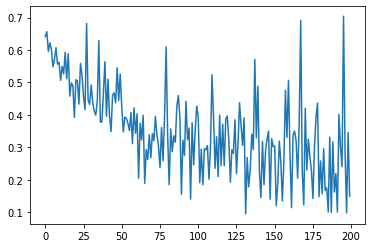

In [345]:
epochs = 10
losses = learner.fit(epochs)
plt.plot(losses)

**Evaluating model**

In [346]:

#Function that calculates accuracy
def accuracy_score(y, predicted):
  correct = sum([y[i]==predicted[i] for i in range(len(y))]).item()
  total = y.size(0)
  return correct/total

model.eval()
test_losses = []
accuracy_list=[]
with torch.no_grad():
  for x, y in test_dl:
    output = model(x)
    loss = loss_func(output, y) #test loss
    test_losses.append(loss.item())
    predicted = torch.max(output.data,1)[1]
    accuracy_list.append(my_accuracy_score(y, predicted) )


accuracy = np.mean(accuracy_list)
test_loss_mean = np.mean(test_losses)

print("Accuracy: ", accuracy)
print("Test_loss: ", test_loss_mean)


Accuracy:  0.8218390804597702
Test_loss:  0.4417245263854663
